In [1]:
import sys
import argparse
import h5py

#!/usr/bin/env python3
"""
Print all keys/paths inside a NeXus (HDF5) file, recursively.

Usage:
    python print_nexus_keys.py path/to/file.nxs
"""


def format_attrs(attrs):
    if not attrs:
        return ""
    parts = []
    for k, v in attrs.items():
        try:
            parts.append(f"{k}={v!r}")
        except Exception:
            parts.append(f"{k}=<unrepresentable>")
    return " [" + ", ".join(parts) + "]"

def explore(node, indent=0):
    pad = "  " * indent
    try:
        name = node.name
    except Exception:
        name = "<unknown>"
    # show group or dataset and any NX_class if present
    try:
        nx_class = node.attrs.get("NX_class")
        nx_str = f" NX_class={nx_class!r}" if nx_class is not None else ""
    except Exception:
        nx_str = ""
    if isinstance(node, h5py.Group):
        print(f"{pad}{name}/ (Group){nx_str}{format_attrs(node.attrs)}")
        # iterate in sorted order for stable output
        try:
            for key in sorted(node.keys()):
                child = node[key]
                explore(child, indent + 1)
        except Exception as e:
            print(f"{pad}  <error listing children: {e}>")
    elif isinstance(node, h5py.Dataset):
        try:
            shape = node.shape
            dtype = node.dtype
            print(f"{pad}{name} (Dataset) shape={shape} dtype={dtype}{nx_str}{format_attrs(node.attrs)}")
        except Exception as e:
            print(f"{pad}{name} (Dataset) <error reading info: {e}>{nx_str}{format_attrs(node.attrs)}")
    else:
        # other HDF5 object (soft link, external link, etc.)
        print(f"{pad}{name} (Unknown type: {type(node)}){nx_str}{format_attrs(getattr(node, 'attrs', {}))}")

def main():
    file = r"C:\Users\leona\OneDrive - Universität Zürich UZH\General - SrCrO3 substrates DIAMOND\data\processing\i21-360903.nxs"

    try:
        with h5py.File(file, "r") as f:
            explore(f, indent=0)
    except OSError as e:
        print(f"Error opening file: {e}", file=sys.stderr)
        sys.exit(2)

if __name__ == "__main__":
    main()

// (Group) [file_name=b'/dls/i21/data/2024/mm36539-2/i21-360903.nxs']
  /entry/ (Group) NX_class=b'NXentry' [NX_class=b'NXentry', default=b'andor']
    /entry/andor/ (Group) NX_class=b'NXdata' [NX_class=b'NXdata', axes=array([b'ds', b'.', b'.'], dtype='|S3'), checkbeam_indices=array([0]), ds_indices=array([0]), signal=b'data']
      /entry/andor/checkbeam (Dataset) shape=(20,) dtype=float64 [local_name=b'checkbeam.checkrc_beamok', target=b'/entry/instrument/checkbeam/checkrc_beamok']
      /entry/instrument/detector/data (Dataset) shape=(20, 2048, 2048) dtype=uint16 [NDArrayDimBinning=array([1, 1]), NDArrayDimOffset=array([0, 0]), NDArrayDimReverse=array([0, 0]), NDArrayNumDims=2, signal=1]
      /entry/andor/ds (Dataset) shape=(20,) dtype=float64 [local_name=b'ds.ds', target=b'/entry/instrument/ds/value']
    /entry/current_script_name (Dataset) shape=() dtype=object [target=b'/entry/diamond_scan/current_script_name']
    /entry/diamond_scan/ (Group) NX_class=b'NXcollection' [NX_class

Explore hdf5

Root attributes:
  - count_time
  - filter_parameters
  - filtertype
  - kernel_size
  - runs
Dataset: /dark_no_spikes  shape=(2048, 2048) dtype=float32
Dataset: /dark_no_spikes_filtered  shape=(2048, 2048) dtype=float32
Dataset: /dark_scaled  shape=(2048, 2048) dtype=float32


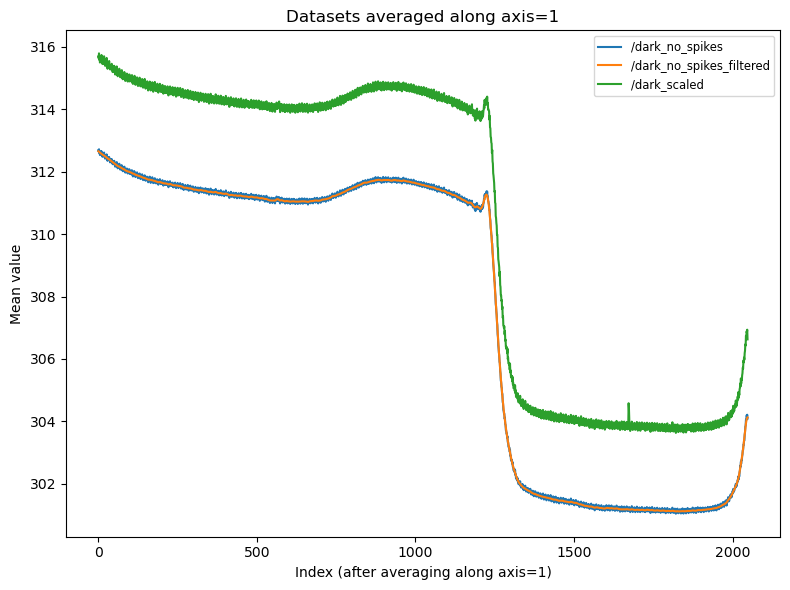

In [2]:
import sys
import h5py
import numpy as np

def print_datasets_and_attr_names(h5_path):
    """
    Recursively print all dataset paths and attribute names for groups/datasets
    in the given HDF5 file.
    """
    def visitor(name, obj):
        # name is the path relative to the file root (no leading slash)
        full_path = "/" + name if name else "/"
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {full_path}  shape={obj.shape} dtype={obj.dtype}")
        else:
            print(f"Group: {full_path}")
        attrs = list(obj.attrs.keys())
        if attrs:
            print("  Attributes:")
            for k in attrs:
                print(f"    - {k}")

    with h5py.File(h5_path, "r") as f:
        # include the root itself
        root_attrs = list(f.attrs.keys())
        if root_attrs:
            print("Root attributes:")
            for k in root_attrs:
                print(f"  - {k}")
        f.visititems(visitor)

# Provide a path interactively (or replace with a literal string)
h5_path = r"C:\Users\leona\OneDrive - Universität Zürich UZH\General - SrCrO3 substrates DIAMOND\data\Leo_python_code\dark_processed_361073_361074_361075.hdf5"
print_datasets_and_attr_names(h5_path)

import matplotlib.pyplot as plt

series = []
labels = []

with h5py.File(h5_path, "r") as f:
    def visitor(name, obj):
        if isinstance(obj, h5py.Dataset):
            try:
                data = obj[()]
            except Exception as e:
                print(f"Could not read dataset /{name}: {e}")
                return
            arr = np.asarray(data)
            if arr.ndim >= 2:
                y = arr.mean(axis=1)
            elif arr.ndim == 1:
                y = arr  # no axis=1 to average over, keep as-is
            else:
                print(f"Skipping /{name}: unsupported ndim={arr.ndim}")
                return
            series.append(y)
            labels.append("/" + name if name else "/")
    f.visititems(visitor)

if not series:
    print("No datasets found to plot.")
else:
    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("tab10")
    for i, y in enumerate(series):
        x = np.arange(y.shape[0])
        plt.plot(x, y, label=labels[i], color=cmap(i % 10))
    plt.xlabel("Index (after averaging along axis=1)")
    plt.ylabel("Mean value")
    plt.title("Datasets averaged along axis=1")
    plt.legend(fontsize="small", loc="best")
    plt.tight_layout()
    plt.show()